In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import plot, show, grid, xlabel, ylabel

In [2]:
price = pd.read_csv("price_sub_date.csv")
price.head()

,Unnamed: 0,Unnamed: 0.1,blockNumber,ETH,DAI,USDC,SUSD,TUSD,USDT,BUSD,...,MKR,REN,REP,SNX,UNI,WBTC,YFI,ZRX,timestamp,Date
0,0,485096,11576735,1,0.001291,0.001285,0.001309,0.001286,0.001284,0.001286,...,0.7732,0.000399,0.021838,0.010441,0.006311,41.769276,28.508944,0.000481,2021-01-02 18:48:02,2021-01-02
1,1,485097,11576738,1,0.001291,0.001285,0.001309,0.001286,0.001284,0.001286,...,0.7732,0.000399,0.021549,0.010441,0.006311,41.769276,28.508944,0.000481,2021-01-02 18:48:45,2021-01-02
2,2,485099,11576739,1,0.001291,0.001285,0.001309,0.001286,0.001284,0.001286,...,0.7732,0.000399,0.021549,0.010441,0.006311,41.769276,28.508944,0.000481,2021-01-02 18:49:03,2021-01-02
3,3,485101,11576744,1,0.001291,0.001285,0.001309,0.001286,0.001284,0.001286,...,0.7732,0.000399,0.021549,0.010441,0.006311,41.769276,28.508944,0.000481,2021-01-02 18:49:34,2021-01-02
4,4,485102,11576746,1,0.001291,0.001285,0.001309,0.001286,0.001284,0.001286,...,0.7732,0.000399,0.021549,0.010441,0.006311,41.769276,28.508944,0.000481,2021-01-02 18:49:48,2021-01-02


In [3]:
print(round(np.mean(price.blockNumber.groupby(price.Date).nunique()),2), 'blocks on average per day.')

251.89 blocks on average per day.


In [4]:
# calculate ETH prices in USDT
price['Price'] = pd.Series()
price['Price'] = price.ETH/price.USDT

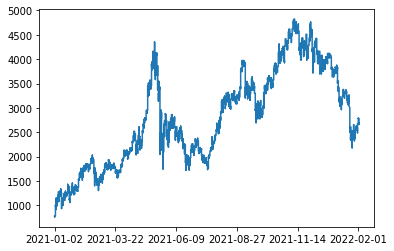

In [5]:
# prices over one year
plt.plot(price.Date, price.Price)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(79))

In [6]:
# june
x,y = price.loc[price['Date']=='2021-06-01'].iloc[0,0], price.loc[price['Date']=='2021-06-30'].iloc[-1,0]
subset = price[x:y+1].reset_index(drop=True)

print(round(np.mean(subset.blockNumber.groupby(subset.Date).nunique()),2), 'blocks on average per day in June.')

248.1 blocks on average per day in June.


In [7]:
'''
example contract
'''

LTVH  = 0.85                  # liquidation threshold LTV
gamma = 0.1                   # contract interest payment

q0   = 6000                   # initial debt

N0   = 3                      # initial number of coins

S0   = subset.Price[0]
C0   = N0*S0                  # collateral
BC0  = LTVH*C0                # borrowing capacity
H0   = q0/(LTVH*N0)           # initial liquidation threshold in unit of price
print('BC =', BC0, '\nH0 =', H0, '\nS(0) =', S0, '\nC(0) =', C0)

LTV0 = q0/C0                  # initial LTV
print('Borrower obtains a loan q =', q0, 'with an initial LTV ratio of LTV =',LTV0)

BC = 6903.079190146284 
H0 = 2352.9411764705883 
S(0) = 2707.089878488739 
C(0) = 8121.269635466217
Borrower obtains a loan q = 6000 with an initial LTV ratio of LTV = 0.7388007379779059


In [8]:
'''
coin liquidation function
'''
def Ni(N0, LTV):
    N = N0*(1-(LTV/(2*LB)))
    
    if LTV > 2*LB:
        N = 0
    if N <= 0.0001:
        N = 0
    
    return N    

In [9]:
pd.options.mode.chained_assignment = None 
contract = subset[['blockNumber', 'Date', 'timestamp', 'Price']]

contract['Threshold'] = pd.Series()
contract.Threshold[0] = H0

contract['Coins'] = pd.Series()
contract.Coins    = N0

contract['Collateral'] = pd.Series()
contract.Collateral[0] = C0

contract['Debt'] = pd.Series()
contract.Debt[0] = q0

contract['LTV'] = pd.Series()
contract.LTV[0] = LTV0

contract['Liquidations'] = pd.Series()
contract.Liquidations    = 0

T  = 61/365           # time horizon compared to one year (for annual interest)
dt = T/len(contract)  # time steps

#contract.head()
#contract

'''
construction of contract over time in two datasets
Assumption: borrower never takes action to avoid liquidation

dataset liqu contains information only about liquidation events; contract is whole development over time
'''

L  = 0           # number of liquidations
LB = 0.95        # liquidation penalty

liqu = contract.iloc[0:1]
for i in range(1, len(contract)):
    # calculate LTV in every block
    contract.Debt[i]       = contract.Debt[i-1]*np.exp(gamma*dt)
    contract.Collateral[i] = contract.Coins[i]*contract.Price[i]
    contract.Threshold[i]  = contract.Debt[i]/(contract.Coins[i]*LTVH)
    contract.LTV[i]        = contract.Debt[i]/contract.Collateral[i]
    
    # check if LTV is too high and calculate liquidation, if necessary
    if contract.LTV[i] >= LTVH:
        # data before liquidation
        liqu.loc[r'$\tau_{}^-$'.format(L)] = contract.iloc[i]
        
        L += 1
        contract.Liquidations[i:] = L
        
        # update data
        contract.Coins[i:]     = Ni(contract.Coins[i], contract.LTV[i])
        
        # delete contract, if all coins gone
        if contract.Coins[i] == 0:
            contract.Debt[i:]       = 0
            contract.Collateral[i:] = 0
            contract.LTV[i:]        = 'NaN'
            contract.Threshold[i:]  = 'NaN'
            break 
            
        contract.Debt[i]       = contract.Debt[i]/2
        contract.Collateral[i] = contract.Coins[i]*contract.Price[i]
        contract.LTV[i]        = contract.Debt[i]/contract.Collateral[i]
        contract.Threshold[i]  = contract.Debt[i]/(contract.Coins[i]*LTVH)
        
        # data after liquidation
        liqu.loc[r'$\tau_{}^+$'.format(L)] = contract.iloc[i]

In [10]:
liqu

,blockNumber,Date,timestamp,Price,Threshold,Coins,Collateral,Debt,LTV,Liquidations
0,12545271,2021-06-01,2021-06-01 00:10:04,2707.089878,2352.941176,3.000000,8121.269635,6000.000000,0.738801,0
$\tau_0^-$,12594676,2021-06-08,2021-06-08 15:24:54,2340.276153,2363.536717,3.000000,7020.828458,6027.018628,0.858448,0
$\tau_1^+$,12594676,2021-06-08,2021-06-08 15:24:54,2340.276153,2155.783526,1.644555,3848.713390,3013.509314,0.782991,1
$\tau_1^-$,12660070,2021-06-18,2021-06-18 18:33:40,2163.893277,2168.176921,1.644555,3558.642009,3030.833693,0.851683,1
$\tau_2^+$,12660070,2021-06-18,2021-06-18 18:33:40,2163.893277,1964.832591,0.907377,1963.466381,1515.416847,0.771807,2
$\tau_2^-$,12677119,2021-06-21,2021-06-21 10:35:25,1956.335242,1967.720019,0.907377,1775.133053,1517.643834,0.854947,2
$\tau_3^+$,12677119,2021-06-21,2021-06-21 10:35:25,1956.335242,1788.744846,0.499083,976.373140,758.821917,0.777184,3
$\tau_3^-$,12684089,2021-06-22,2021-06-22 12:46:55,1771.793055,1790.179277,0.499083,884.271321,759.430432,0.858821,3
$\tau_4^+$,12684089,2021-06-22,2021-06-22 12:46:55,1771.793055,1633.407579,0.273492,484.571093,379.715216,0.783611,4


In [11]:
contract.tail()

,blockNumber,Date,timestamp,Price,Threshold,Coins,Collateral,Debt,LTV,Liquidations
7438,12738400,2021-06-30,2021-06-30 23:35:58,2257.85,1640.291484,0.273492,617.503743,381.315504,0.617511,4
7439,12738417,2021-06-30,2021-06-30 23:38:54,2257.85,1640.295167,0.273492,617.503743,381.316361,0.617513,4
7440,12738483,2021-06-30,2021-06-30 23:54:48,2257.85,1640.298850,0.273492,617.503743,381.317217,0.617514,4
7441,12738501,2021-06-30,2021-06-30 23:58:26,2257.85,1640.302533,0.273492,617.503743,381.318073,0.617515,4
7442,12738502,2021-06-30,2021-06-30 23:58:30,2257.85,1640.306216,0.273492,617.503743,381.318929,0.617517,4


In [12]:
# translate into .tex table
print(liqu.to_latex(float_format="%.2f"))

\begin{tabular}{lrllrrrrrrr}
\toprule
{} &  blockNumber &        Date &            timestamp &   Price &  Threshold &  Coins &  Collateral &    Debt &  LTV &  Liquidations \\
\midrule
0          &     12545271 &  2021-06-01 &  2021-06-01 00:10:04 & 2707.09 &    2352.94 &   3.00 &     8121.27 & 6000.00 & 0.74 &             0 \\
\$\textbackslash tau\_0\textasciicircum -\$ &     12594676 &  2021-06-08 &  2021-06-08 15:24:54 & 2340.28 &    2363.54 &   3.00 &     7020.83 & 6027.02 & 0.86 &             0 \\
\$\textbackslash tau\_1\textasciicircum +\$ &     12594676 &  2021-06-08 &  2021-06-08 15:24:54 & 2340.28 &    2155.78 &   1.64 &     3848.71 & 3013.51 & 0.78 &             1 \\
\$\textbackslash tau\_1\textasciicircum -\$ &     12660070 &  2021-06-18 &  2021-06-18 18:33:40 & 2163.89 &    2168.18 &   1.64 &     3558.64 & 3030.83 & 0.85 &             1 \\
\$\textbackslash tau\_2\textasciicircum +\$ &     12660070 &  2021-06-18 &  2021-06-18 18:33:40 & 2163.89 &    1964.83 &   0.91 &     196

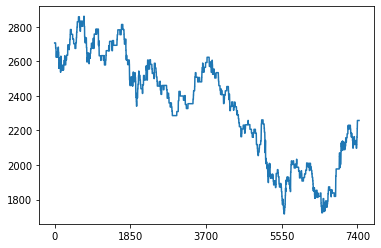

In [13]:
fig, ax = plt.subplots()

ax.plot(contract.Price)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1850))
plt.show()

In [14]:
# Added block time
labels = []
for item in ax.get_xticklabels():
    d = int(item.get_unitless_position()[0])
    try:
        labels.append(contract.Date[d])
    except:
        labels.append(' ')

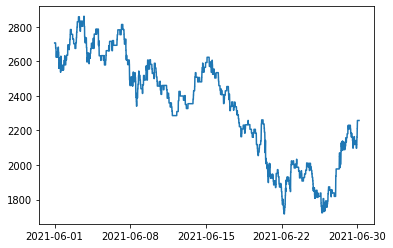

In [15]:
fig, ax = plt.subplots()

ax.plot(contract.Price)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1850))
ax.set_xticklabels(labels)
plt.show()

In [16]:
liqu_index = []
for item in range(L):
    liqu_index.append(contract[(contract.Liquidations == item)].iloc[0].name)
    
liqu_index

[0, 2001, 4554, 5208]

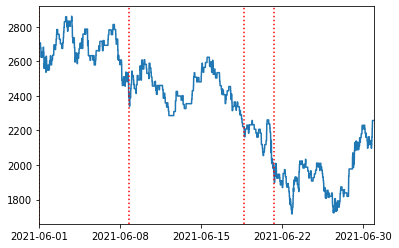

In [17]:
fig, ax = plt.subplots()

plt.plot(contract.index, contract.Price)
for i in range(len(liqu_index)):
    plt.axvline(x = liqu_index[i], color='r', linestyle=':')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1800))
ax.set_xticklabels(labels)

plt.margins(0,0.05)
#plt.savefig('liquidations_june.png', transparent=True)
plt.show()

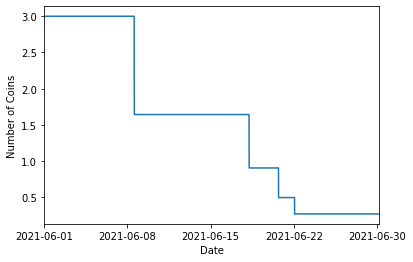

Development of the number of coins in a loan that suffered from 4 liquidations in total


In [18]:
fig, ax = plt.subplots()

ax.plot(contract.Coins)
ax.set_xticklabels(labels)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1850))
xlabel('Date')
ylabel('Number of Coins')

plt.margins(0,0.05)
#plt.savefig('coins_june.png', transparent=True)
show()
print('Development of the number of coins in a loan that suffered from', contract.Liquidations.iloc[-1], 'liquidations in total')

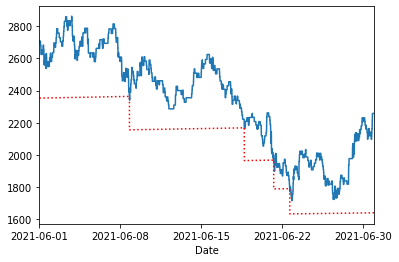

In [19]:
fig, ax = plt.subplots()

ax.plot(contract.Price)
ax.plot(contract.Threshold, label='Price Threshold', color='r', linestyle=':')
#ax.plot(contract.Threshold, label='Price Threshold', color='r', linestyle='dashed')
ax.set_xticklabels(labels)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1800))

xlabel('Date')

plt.margins(0,0.05)
#plt.savefig('pricethreshold_june.png', transparent=True)
show()

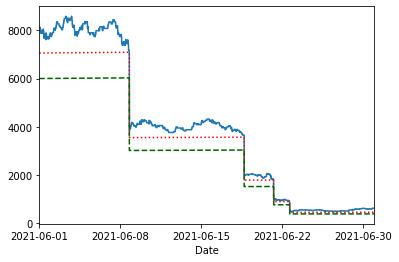

In [20]:
fig, ax = plt.subplots()

ax.plot(contract.Collateral)
ax.plot(contract.Threshold*contract.Coins, color='r', linestyle=':')
ax.plot(contract.Debt, color='darkgreen', linestyle='dashed')
ax.set_xticklabels(labels)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1800))

xlabel('Date')

plt.margins(0,0.05)
#plt.savefig('collateral_june.png', transparent=True)
show()